# Image segmentation with the Camvid dataset

In [2]:
from fastai.vision import *
from fastai import *
%matplotlib inline

## Loading the dataset

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/anass/.fastai/data/camvid/labels'),
 PosixPath('/home/anass/.fastai/data/camvid/images'),
 PosixPath('/home/anass/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/anass/.fastai/data/camvid/codes.txt')]

the data contains :

* `codes.txt` wich contains the codes for each labels 
* `images` folder that contains the training images
* `labels` for the correct segmentation of the images

### Creating the data sources

In [10]:
#loadin the codes
codes = np.loadtxt(path/'codes.txt',dtype=str)

camvid_images = path/'images'
camvid_labels = path/'labels'

PosixPath('/home/anass/.fastai/data/camvid/images/0001TP_008130.png')

In [13]:
#Let check the relation between the images and labels
print("image :",camvid_images.ls()[0])
print("label :",camvid_labels.ls()[0])

image : /home/anass/.fastai/data/camvid/images/0001TP_008130.png
label : /home/anass/.fastai/data/camvid/labels/0006R0_f01740_P.png


We could that the relation is with take the **final name** and with add the **_P** and the **extension**. so we could create a function to associate those names

In [23]:
get_y_f = lambda x: camvid_labels/f'{x.stem}_P{x.suffix}'

torch.Size([1, 720, 960])


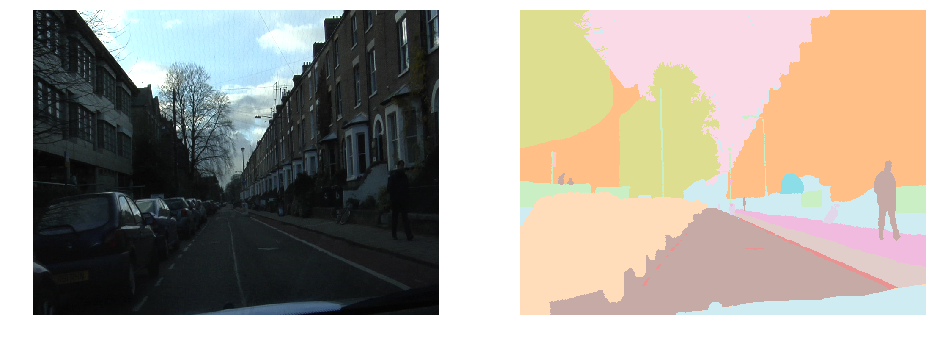

In [43]:
#list the images names to visualize them
image_fnames = get_image_files(camvid_images)
img = open_image(image_fnames[14])

#loading the mask
img_label = open_mask(get_y_f(image_fnames[14]))
#getting the associated label
fig,axs = plt.subplots(1,2,figsize=(16,8))
img.show(ax=axs[0])
img_label.show(ax=axs[1])

In [61]:
src_size = np.array(img_label.shape[1:])
batch_size = 4
data = (SegmentationItemList.from_folder(camvid_images)       #initial images lists
       .split_by_fname_file("../valid.txt")                           #split by random validation set
       .label_from_func(get_y_f,classes=codes)
       .transform(get_transforms(),size=src_size//4,tfm_y=True)                                   #transformtion
       .databunch(bs=batch_size)                                  # To a databunch
       .normalize(imagenet_stats)
      )
print(data)

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240)
y: SegmentationLabelList
ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240)
Path: /home/anass/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240)
y: SegmentationLabelList
ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240)
Path: /home/anass/.fastai/data/camvid/images;

Test: None


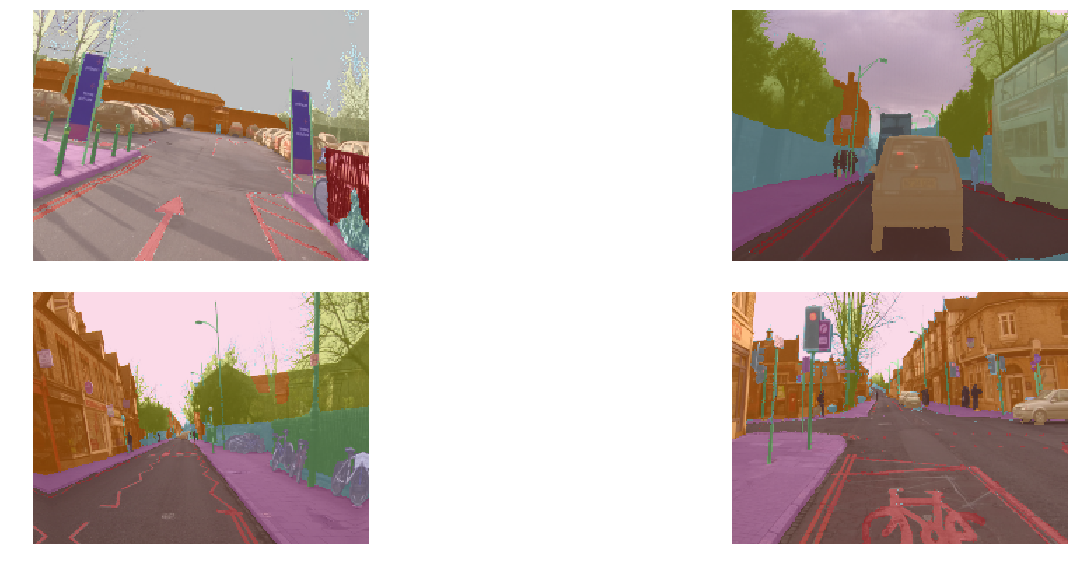

In [62]:
data.show_batch(2,figsize=(24,8))

## Metrics for segmentation

We need to create a special **metric** with doesn't penalize the non recognasable categories

In [55]:
name2id = {v:k for k,v in enumerate(codes)}        #names to id 
void_code = name2id['Void']                     # entry for non recognazable category

def acc_camvid(input, target):
    target = target.squeeze(1)                 #squeeze to 1d array
    mask = target != void_code                 # mask non rocognaziable categories
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

## U-net Learner

In [63]:
learner = unet_learner(data,models.resnet34, metrics = [acc_camvid])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


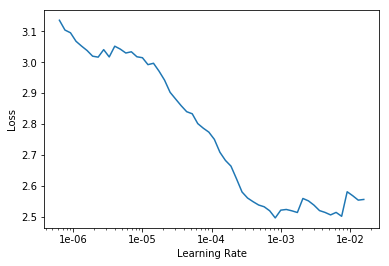

In [64]:
#finding the learner rate
learner.lr_find()
learner.recorder.plot()

In [66]:
lr= 0.5e-3

In [67]:
learner.fit_one_cycle(10, max_lr=slice(lr, lr/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.590013,1.129450,0.739976,00:28
1,0.990953,0.862383,0.774593,00:26
2,0.781143,0.737091,0.805503,00:26
3,0.680822,0.589674,0.839445,00:26
4,0.615555,0.546967,0.843175,00:26
5,0.560499,0.504663,0.859602,00:26
6,0.498406,0.422602,0.874516,00:26
7,0.468796,0.418398,0.876067,00:26
8,0.459801,0.397137,0.882570,00:26
9,0.444366,0.396462,0.883723,00:26


 Wet get a $80$ Just by transfer learning that amazing. 

> Also we used a smaller batch size and image size due to the limitation of   my graphic card with only 8G memory

In [68]:
learner.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


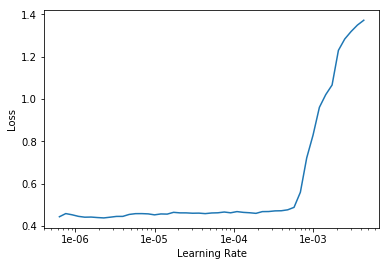

In [69]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [71]:
lr=  1e-5

In [72]:
learner.fit_one_cycle(12,lr)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.445473,0.396707,0.883854,00:29
1,0.447489,0.393847,0.884250,00:29
2,0.435593,0.405013,0.881753,00:29
3,0.432104,0.391840,0.885529,00:29
4,0.430728,0.386509,0.887614,00:29
5,0.425204,0.392137,0.883030,00:29
6,0.407462,0.386559,0.885889,00:29
7,0.410918,0.384406,0.885463,00:29
8,0.406721,0.373952,0.889699,00:29
9,0.399107,0.379188,0.888671,00:28


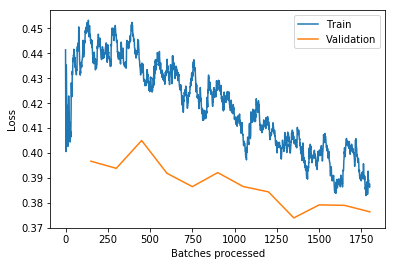

In [77]:
#let's plot the losses
learner.recorder.plot_losses()

As illustratetd in the plot, we `validatin` loss is smaller than the `training` loss.  The is a clear indication that the model is underfitting. We could enhance that by considering a bigger size

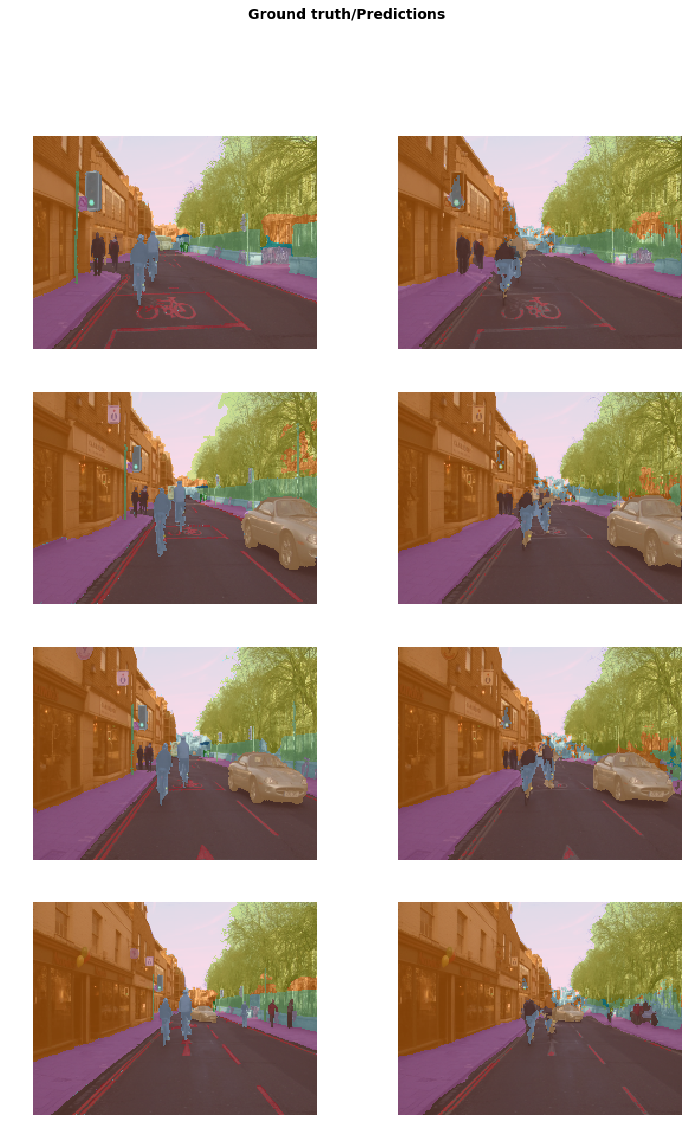

In [81]:
learner.show_results(figsize=(12,18))

In [82]:
dddoc(learner.show_results)